# Step 5.4: Deep Learning - Autoencoder

In [1]:
# Import standard libraries
import os

# Import installed libraries
import numpy as np
import pandas as pd
import sklearn

from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [3]:
# Let's mount the Google Drive, where we store files and models (if applicable, otherwise work
# locally)
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""

In [4]:
# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [5]:
# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())

In [6]:
# In this example we create a single test-training split with a ratio of 0.8 / 0.2
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]

In [100]:
# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the training data to fit
# the scaler
#scaler = preprocessing.MinMaxScaler().fit(X_train)
#scaler = preprocessing.StandardScaler().fit(X_train)



# Transform now the training data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = np.array([k-np.min(k) for k in X_train])
X_test_scaled = np.array([k-np.min(k) for k in X_test])

In [8]:
import tensorflow.keras as keras

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [ ]:
from matplotlib import pyplot
n_inputs = asteroids_X.shape[1]
print(n_inputs)

# define encoder
visible = keras.layers.Input(shape=(n_inputs,))

e = keras.layers.Dense(30)(visible)
e = keras.layers.BatchNormalization()(e)
#e = keras.layers.LeakyReLU()(e)

e = keras.layers.Dense(10)(e)
e = keras.layers.BatchNormalization()(e)
#e = keras.layers.LeakyReLU()(e)

n_bottleneck = 2
#bottleneck = keras.layers.Dense(n_bottleneck, activity_regularizer=keras.regularizers.l1(10e-5))(e)
bottleneck = keras.layers.Dense(n_bottleneck, activation='sigmoid')(e)
bottleneck = keras.layers.BatchNormalization()(bottleneck)

d = keras.layers.Dense(10)(bottleneck)
d = keras.layers.BatchNormalization()(d)
#d = keras.layers.LeakyReLU()(d)


# define decoder, level 1
d = keras.layers.Dense(30)(d)
d = keras.layers.BatchNormalization()(d)
#d = keras.layers.LeakyReLU()(d)

output = keras.layers.Dense(n_inputs)(d)
# define autoencoder model
model = keras.models.Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train_scaled, X_train_scaled, epochs=100, batch_size=8, verbose=2, validation_data=(X_test_scaled,X_test_scaled))
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

49
Epoch 1/100
134/134 - 1s - loss: 0.1015 - val_loss: 0.0159
Epoch 2/100
134/134 - 0s - loss: 0.0043 - val_loss: 0.0083
Epoch 3/100
134/134 - 0s - loss: 0.0027 - val_loss: 0.0045
Epoch 4/100
134/134 - 0s - loss: 0.0027 - val_loss: 0.0012
Epoch 5/100
134/134 - 0s - loss: 0.0029 - val_loss: 6.8034e-04
Epoch 6/100
134/134 - 0s - loss: 0.0028 - val_loss: 7.3283e-04
Epoch 7/100
134/134 - 0s - loss: 0.0029 - val_loss: 9.3767e-04
Epoch 8/100
134/134 - 0s - loss: 0.0030 - val_loss: 0.0011
Epoch 9/100
134/134 - 0s - loss: 0.0025 - val_loss: 8.3340e-04
Epoch 10/100


In [125]:
encoder = keras.models.Model(inputs=visible, outputs=bottleneck)

X_train_encoded = encoder.predict(X_train_scaled)
encoded_train_df = pd.DataFrame(np.hstack((X_train_encoded, y_train[np.newaxis].transpose())), columns=["enc1", "enc2", "class"])

#X_train_encoded = encoder.predict(X_test_scaled)
#encoded_train_df = pd.DataFrame(np.hstack((X_train_encoded, y_test[np.newaxis].transpose())), columns=["enc1", "enc2", "class"])

encoded_train_df.loc[:, "enc1"] = encoded_train_df["enc1"].astype(float)
encoded_train_df.loc[:, "enc2"] = encoded_train_df["enc2"].astype(float)
#encoded_train_df.loc[:, "enc3"] = encoded_train_df["enc3"].astype(float)

#encoded_train_df.apply(lambda x: color_dict.get(x["class"]), axis=1)–

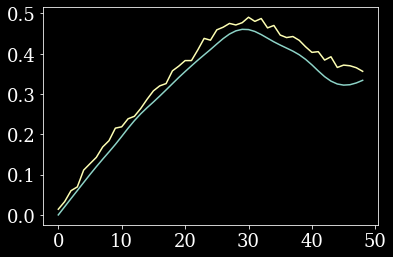

In [126]:
plt.figure()
plt.plot(X_train_scaled[150])
plt.plot(model.predict(X_train_scaled)[150])



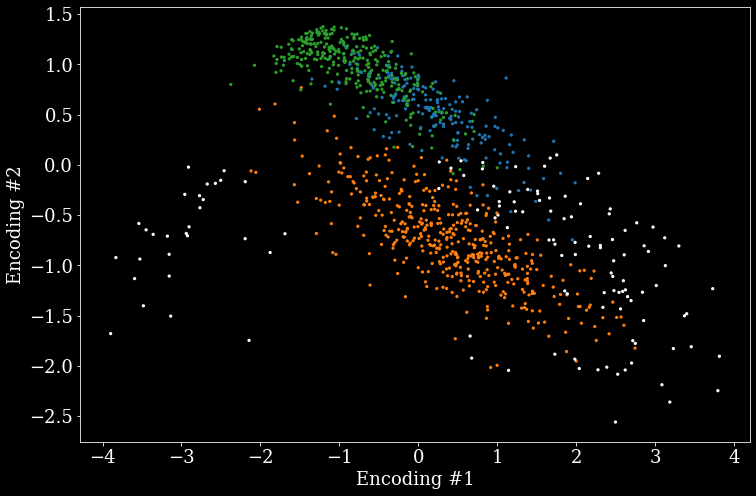

In [127]:
from matplotlib import pyplot as plt
# Set the dark mode and the font size and style

color_dict = {'Other': 'w',
              'S': 'tab:orange',
              'C': 'tab:green',
              'X': 'tab:blue'}

plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

plt.figure(figsize=(12,8))

plt.scatter(encoded_train_df["enc1"], encoded_train_df["enc2"], marker='o', s=5, alpha=1, color=encoded_train_df.apply(lambda x: color_dict.get(x["class"]), axis=1).values)

plt.xlabel("Encoding #1")
plt.ylabel("Encoding #2")

plt.savefig("temp.png")
plt.show()